# Bayesian Neural Network with Jax

- Resources: https://github.com/jamesvuc/jax-bayes

In [29]:
# %%
import numpy as np
np.random.seed(0)

import haiku as hk

import jax.numpy as jnp
import jax

from tqdm import tqdm, trange
from matplotlib import pyplot as plt

from jax_bayes.utils import confidence_bands
from jax_bayes.mcmc import (
	# langevin_fns,
	mala_fns,
	# hmc_fns,
)

#could use any of the samplers modulo hyperparameters
# sampler_fns = hmc_fns
# sampler_fns = langevin_fns
sampler_fns = mala_fns

def build_dataset():
	n_train, n_test, d = 200, 100, 1
	xlims = [-1.0, 5.0]
	x_train = np.random.rand(n_train, d) * (xlims[1] - xlims[0]) + xlims[0]
	x_test = np.random.rand(n_test, d) * (xlims[1] - xlims[0]) + xlims[0]

	target_func = lambda t: (np.log(t + 100.0) * np.sin(1.0 * np.pi*t)) + 0.1 * t

	y_train = target_func(x_train)
	y_test = target_func(x_test)

	y_train += np.random.randn(*x_train.shape) * (1.0 * (x_train + 2.0)**0.5)

	return (x_train, y_train), (x_test, y_test)

def net_fn(x):

	mlp = hk.Sequential([
		hk.Linear(128, w_init=hk.initializers.Constant(0), 
					   b_init=hk.initializers.Constant(0)), 
		jnp.tanh, 
		hk.Linear(1,   w_init=hk.initializers.Constant(0), 
					   b_init=hk.initializers.Constant(0))
		])

	return mlp(x)

In [30]:
# ======= Setup =======
xy_train, xy_test = build_dataset()
(x_train, y_train), (x_test, y_test) = xy_train, xy_test

In [31]:
x_train.shape

(200, 1)

In [32]:
y_train.shape

(200, 1)

In [33]:
x_test.shape

(100, 1)

In [63]:
# lr = 1e-3
# reg = 0.1
# lik_var = 0.5

# lr = 1e-1
lr = 1e-4
reg = 0.1
lik_var = 0.5

net = hk.transform(net_fn)
key = jax.random.PRNGKey(0)

sampler_init, sampler_propose, sampler_accept, sampler_update, sampler_get_params = \
    sampler_fns(key, num_samples=11, step_size=lr, init_stddev=5.0)

In [64]:
def logprob(params, xy):
    """ log posterior, assuming 
    P(params) ~ N(0,eta)
    P(y|x, params) ~ N(f(x;params), lik_var)
    """
    x, y = xy

    preds = net.apply(params, None, x)
    log_prior = - reg * sum(jnp.sum(jnp.square(p)) 
                        for p in jax.tree_leaves(params))
    log_lik = - jnp.mean(jnp.square(preds - y)) / lik_var
    return log_lik + log_prior

@jax.jit
def sampler_step(i, state, keys, batch):
    # print(state)
    # input()
    params = sampler_get_params(state)
    logp = lambda params:logprob(params, batch)
    fx, dx = jax.vmap(jax.value_and_grad(logp))(params)

    fx_prop, dx_prop = fx, dx
    # fx_prop, prop_state, dx_prop, new_keys = fx, state, dx, keys
    prop_state, keys = sampler_propose(i, dx, state, keys)

    # for RK-langevin and MALA --- recompute gradients
    prop_params = sampler_get_params(prop_state)
    fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    # for HMC
    # prop_state, dx_prop, keys = state, dx, keys
    # for j in range(5): #5 iterations of the leapfrog integrator
    # 	prop_state, keys = \
    # 		sampler_propose(i, dx_prop, prop_state, keys)

    # 	prop_params = sampler_get_params(prop_state)
    # 	fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    accept_idxs, keys = sampler_accept(
        i, fx, fx_prop, dx, state, dx_prop, prop_state, keys
    )
    state, keys = sampler_update(
        i, accept_idxs, dx, state, dx_prop, prop_state, keys
    )


    return state, keys

In [65]:
# ======= Sampling ======

# initialization
params = net.init(jax.random.PRNGKey(42), x_train)

In [66]:
params['linear']['w'].shape

(1, 128)

In [67]:
sampler_state, sampler_keys = sampler_init(params)

In [68]:
#do the sampling
for step in trange(5000):
    sampler_state, sampler_keys = \
        sampler_step(step, sampler_state, sampler_keys, xy_train)


sampler_params = sampler_get_params(sampler_state)

  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-64-34c999bbf60f>:10: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  for p in jax.tree_leaves(params))
100%|██████████| 5000/5000 [00:07<00:00, 640.63it/s]


In [69]:
sampler_params['linear']['w'].shape

(11, 1, 128)

In [75]:
# ========= Plotting ========
plot_inputs = np.linspace(-1, 30, num=600).reshape(-1,1)
outputs = jax.vmap(net.apply, in_axes=(0, None, None))(sampler_params, None, plot_inputs)

In [76]:
plot_inputs.shape

(600, 1)

In [77]:
outputs.shape

(11, 600, 1)

In [78]:
outputs.squeeze(-1).T.shape

(600, 11)

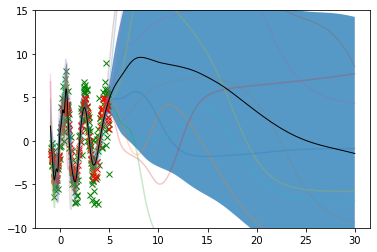

In [79]:
lower, upper = confidence_bands(outputs.squeeze(-1).T)

f, ax = plt.subplots(1)

ax.plot(x_train.ravel(), y_train.ravel(), 'x', color='green')
ax.plot(x_test.ravel(), y_test.ravel(), 'x', color='red')
for i in range(outputs.shape[0]):
    ax.plot(plot_inputs, outputs[i], alpha=0.25)
ax.plot(plot_inputs, np.mean(outputs[:, :, 0].T, axis=1), color='black', 
        linewidth=1.0)
ax.fill_between(plot_inputs.squeeze(-1), lower, upper, alpha=0.75)

ax.set_ylim(-10, 15)

plt.show()